In [ ]:
import yaml

from utils.datasets import create_dataloader
from utils.general import check_dataset
from utils.plots import plot_images
from types import SimpleNamespace

opt = {
    "single_cls": True,
    "data": "/home1/07265/egoh/work/SLICE/yolov7/data/sar.yaml",
    "img_size": [640, 640],
    "batch_size": 36,
    "hyp": "/home1/07265/egoh/work/SLICE/yolov7/data/hyp.scratch.p5.yaml",  # hyperparams path
    "cache_images": False,  # cache images for faster training
    "rect": False,
    "world_size": 1,
    "workers": 8,
    "image_weights": False,
    "quad": False,
    "use_sar_dataset": True,
    "sar_coco_annotation_file": "/home1/07265/egoh/work/SLICE/eddydet/data/processed/coco_annotations.json"
}
opt = SimpleNamespace(**opt)  # convert to SimpleNamespace for compatibility
hyp = opt.hyp
batch_size = opt.batch_size
with open(opt.data) as f:
    data_dict = yaml.load(f, Loader=yaml.SafeLoader)  # data dict
gs = 32
rank = -1
imgsz, imgsz_test = opt.img_size  # TODO: understand relationship between model.stride.max() and grid_size
check_dataset(data_dict)  # check
train_path = data_dict['train']
dataloader, dataset = create_dataloader(train_path, imgsz, batch_size, gs, opt,
                                            hyp=hyp, augment=True, cache=opt.cache_images, rect=opt.rect, rank=rank,
                                            world_size=opt.world_size, workers=opt.workers,
                                            image_weights=opt.image_weights, quad=opt.quad, prefix='train: ')
print(len(dataset))
img, labels_out, file, shapes = dataset[10]
print(f"{img.shape=}\n{labels_out.shape=}\n{labels_out=}\n{file=}\n{shapes=}")
# plot_images(img.unsqueeze(0), labels_out, file, names=None, max_size=640) # Changed labels_out.unsqueeze(0) to labels_out

import random
# Skip a random number of batches
skip_batches = random.randint(0, len(dataloader) - 1)
data_iter = iter(dataloader)
for _ in range(skip_batches):
    next(data_iter)
imgs, targets, paths, _ = next(data_iter)
moisaic = plot_images(imgs, targets, paths, names=None, max_size=640, max_subplots=36)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
279
img.shape=torch.Size([3, 640, 640])
labels_out.shape=torch.Size([0, 6])
labels_out=tensor([], size=(0, 6))
file='S1A_IW_GRDH_1SDV_20151206T052036_20151206T052104_008917_00CC34_786E_masked.tif_win10'
shapes=((640, 640), ((1.0, 1.0), (0.0, 0.0)))


: 

In [ ]:
import random
import pandas as pd
df = pd.read_excel("data/WESTMEDEddies_Gade_engl_orig.xlsx")

# return a stratified sample of "File Name"s based on their value counts
# Steps:
# 1. Get value counts of "File Name"
# 2. Get histogram of value counts (bin_count = number of images we want, but exclude outliers)
# 3. Based on relative frequencies, randomly sample file names from each bin
def stratified_sample(df, num_samples=10):
    value_counts = df['File Name'].value_counts()
    print(value_counts.describe())
    from astropy.stats import freedman_bin_width
    # drop outliers; keep only 2 sigma left and right of median
    value_counts = remove_outliers(value_counts)
    print(f"Filtered value counts:\n{value_counts.describe()}")
    # sort everything into bins
    bin_width = freedman_bin_width(value_counts)
    bin_edges = [value_counts.min() + i * bin_width for i in range(int((value_counts.max() - value_counts.min()) / bin_width) + 1)]
    bins = pd.cut(value_counts, bins=bin_edges, include_lowest=True)
    print(f"Bins:\n{bins}")
    # Sample from each bin
    sampled_files = []
    for bin in bins.cat.categories:
        bin_files = value_counts[bins == bin].index.tolist()
        if len(bin_files) > 0:
            sampled_file = random.choice(bin_files)
            sampled_files.append(sampled_file)
    # Limit the number of samples to num_samples
    if len(sampled_files) > num_samples:
        sampled_files = random.sample(sampled_files, num_samples)
    return sampled_files
    

def remove_outliers(value_counts):
    median = value_counts.median()
    std_dev = value_counts.std()
    lower_bound = median - 2 * std_dev
    upper_bound = median + 2 * std_dev
    value_counts = value_counts[(value_counts >= lower_bound) & (value_counts <= upper_bound)]
    return value_counts

def stratified_by_count(df, k=10):
    # how many labels per image
    counts = df["File Name"].value_counts()
    # define k equal-sized bins
    bins = pd.qcut(counts, q=k, labels=False, duplicates='drop')
    sampled = []
    for b in sorted(bins.unique()):
        candidates = counts[bins == b].index.tolist()
        # sampled.append(random.choice(candidates))
        # choose file with highest count in bin
        # sampled.append(counts[candidates].idxmax())
        # choose file with median count in bin
        median_count = counts[bins == b].median()
        # file_closest_to_median = counts[bins == b].sub(median_count).abs().idxmin()
        five_files_closest_to_median = counts[bins == b].nsmallest(5).index.tolist()
        # randomly select one of the five closest to median
        file_closest_to_median = random.choice(five_files_closest_to_median)
        sampled.append(file_closest_to_median)
    return sampled

# sampled_files = stratified_sample(df, num_samples=20)
sampled_files = stratified_by_count(df, k=30)
for file in sampled_files:
    print(f"{file} (count: {df[df['File Name'] == file].shape[0]})")

# from astropy.visualization import hist
# import matplotlib.pyplot as plt

# Plot histogram of value counts
# value_counts = df['File Name'].value_counts()
# value_counts = remove_outliers(value_counts)  # Remove outliers before plotting
# plt.figure(figsize=(10, 6))
# hist(value_counts, bins="blocks", label='File Name Counts')

S1A_IW_GRDH_1SDV_20170405T061030_20170405T061055_016005_01A670_C533 (count: 1)
S1A_IW_GRDH_1SDV_20170515T053640_20170515T053705_016588_01B83E_C58C (count: 3)
S1A_IW_GRDH_1SDV_20161231T051142_20161231T051207_014619_017C44_F8CF (count: 4)
S1A_IW_GRDH_1SDV_20160904T173716_20160904T173741_012906_01465D_4EFE (count: 5)
S1A_IW_GRDH_1SDV_20161018T052848_20161018T052913_013540_015AB8_EB50 (count: 6)
S1A_IW_GRDH_1SDV_20141019T051229_20141019T051254_002894_003475_3153 (count: 7)
S1A_IW_GRDH_1SDV_20150830T053608_20150830T053633_007488_00A55C_1E01 (count: 9)
S1A_IW_GRDH_1SDV_20141121T172930_20141121T172955_003383_003EF5_25B3 (count: 10)
S1A_IW_GRDH_1SDV_20160924T052913_20160924T052938_013190_014FA5_A16C (count: 13)
S1A_IW_GRDH_1SDV_20170115T181749_20170115T181814_014846_018332_D7DA (count: 17)
S1A_IW_GRDH_1SDV_20160914T051209_20160914T051234_013044_014AB8_92E0 (count: 23)
S1A_IW_GRDH_1SDV_20150903T050401_20150903T050426_007546_00A6E6_57C3 (count: 39)


/work/07265/egoh/vista/vista_miniconda3/envs/slice_env_2/lib/python3.13/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [41]:
def stratified_by_count(df, k=10):
    # how many labels per image
    counts = df["File Name"].value_counts()
    # define k equal-sized bins
    bins = pd.qcut(counts, q=k, labels=False, duplicates='drop')
    sampled = []
    for b in sorted(bins.unique()):
        candidates = counts[bins == b].index.tolist()
        # sampled.append(random.choice(candidates))
        # choose file with highest count in bin
        # sampled.append(counts[candidates].idxmax())
        # choose file with median count in bin
        median_count = counts[bins == b].median()
        # file_closest_to_median = counts[bins == b].sub(median_count).abs().idxmin()
        five_files_closest_to_median = counts[bins == b].nsmallest(5).index.tolist()
        # randomly select one of the five closest to median
        file_closest_to_median = random.choice(five_files_closest_to_median)
        sampled.append(file_closest_to_median)
    return sampled

sampled_files = stratified_by_count(df, k=30)
for file in sampled_files:
    print(f"{file} (count: {df[df['File Name'] == file].shape[0]})")


S1A_IW_GRDH_1SDV_20170326T165624_20170326T165649_015866_01A24E_C46C (count: 1)
S1A_IW_GRDH_1SDV_20161113T175310_20161113T175335_013927_0166BB_D864 (count: 3)
S1A_IW_GRDH_1SDV_20170413T174520_20170413T174545_016129_01AA39_85D8 (count: 4)
S1A_IW_GRDH_1SDV_20170107T174520_20170107T174545_014729_017F92_3EA8 (count: 5)
S1A_IW_GRDH_1SDV_20161029T172940_20161029T173005_013708_015FD5_1355 (count: 6)
S1A_IW_GRDH_1SDV_20141204T052803_20141204T052828_003565_00434C_B1EA (count: 7)
S1A_IW_GRDH_1SDV_20161113T175425_20161113T175450_013927_0166BB_0BE8 (count: 8)
S1A_IW_GRDH_1SDV_20160921T174612_20160921T174637_013154_014E66_B0FD (count: 10)
S1A_IW_GRDH_1SDV_20170301T175331_20170301T175356_015502_019766_6652 (count: 12)
S1A_IW_GRDH_1SDV_20170129T180138_20170129T180203_015050_018978_C931 (count: 15)
S1A_IW_GRDH_1SDV_20161018T052758_20161018T052823_013540_015AB8_FC43 (count: 20)
S1A_IW_GRDH_1SDV_20161223T172220_20161223T172245_014510_0178EB_87A0 (count: 29)


In [45]:
sampled_files

['S1A_IW_GRDH_1SDV_20170326T165624_20170326T165649_015866_01A24E_C46C',
 'S1A_IW_GRDH_1SDV_20161113T175310_20161113T175335_013927_0166BB_D864',
 'S1A_IW_GRDH_1SDV_20170413T174520_20170413T174545_016129_01AA39_85D8',
 'S1A_IW_GRDH_1SDV_20170107T174520_20170107T174545_014729_017F92_3EA8',
 'S1A_IW_GRDH_1SDV_20161029T172940_20161029T173005_013708_015FD5_1355',
 'S1A_IW_GRDH_1SDV_20141204T052803_20141204T052828_003565_00434C_B1EA',
 'S1A_IW_GRDH_1SDV_20161113T175425_20161113T175450_013927_0166BB_0BE8',
 'S1A_IW_GRDH_1SDV_20160921T174612_20160921T174637_013154_014E66_B0FD',
 'S1A_IW_GRDH_1SDV_20170301T175331_20170301T175356_015502_019766_6652',
 'S1A_IW_GRDH_1SDV_20170129T180138_20170129T180203_015050_018978_C931',
 'S1A_IW_GRDH_1SDV_20161018T052758_20161018T052823_013540_015AB8_FC43',
 'S1A_IW_GRDH_1SDV_20161223T172220_20161223T172245_014510_0178EB_87A0']

In [44]:
train = [
    "S1A_IW_GRDH_1SDV_20141121T172930_20141121T172955_003383_003EF5_25B3",
    "S1A_IW_GRDH_1SDV_20141019T051229_20141019T051254_002894_003475_3153",
    "S1A_IW_GRDH_1SDV_20160904T173716_20160904T173741_012906_01465D_4EFE",
    "S1A_IW_GRDH_1SDV_20150903T050401_20150903T050426_007546_00A6E6_57C3",
    "S1A_IW_GRDH_1SDV_20170115T181749_20170115T181814_014846_018332_D7DA",
    "S1A_IW_GRDH_1SDV_20160914T051209_20160914T051234_013044_014AB8_92E0",
    "S1A_IW_GRDH_1SDV_20160924T052913_20160924T052938_013190_014FA5_A16C",
    "S1A_IW_GRDH_1SDV_20161018T052848_20161018T052913_013540_015AB8_EB50",
    "S1A_IW_GRDH_1SDV_20170405T061030_20170405T061055_016005_01A670_C533",
    "S1A_IW_GRDH_1SDV_20170515T053640_20170515T053705_016588_01B83E_C58C",
    "S1A_IW_GRDH_1SDV_20161231T051142_20161231T051207_014619_017C44_F8CF",
    "S1A_IW_GRDH_1SDV_20150830T053608_20150830T053633_007488_00A55C_1E01",
]
(set(sampled_files) - set(train))  == set(sampled_files)

True

<Axes: >

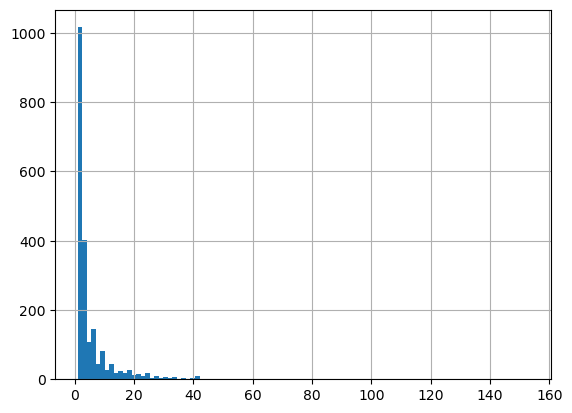

In [5]:
df["File Name"].value_counts().hist(bins=100)